# Import the necessary libraries

In [130]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler

In [2]:
water_data = pd.read_csv('C:/Users/CHUKS/Desktop/projects/water_potability.csv')
water_data.head()

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  Organic_carbon  \
0  NaN    204.89 20791.32         7.30   368.52        564.31           10.38   
1 3.72    129.42 18630.06         6.64      NaN        592.89           15.18   
2 8.10    224.24 19909.54         9.28      NaN        418.61           16.87   
3 8.32    214.37 22018.42         8.06   356.89        363.27           18.44   
4 9.09    181.10 17978.99         6.55   310.14        398.41           11.56   

   Trihalomethanes  Turbidity  Potability  
0            86.99       2.96           0  
1            56.33       4.50           0  
2            66.42       3.06           0  
3           100.34       4.63           0  
4            32.00       4.08           0

In [3]:
water_data.shape # To check the number of rows and columns in the dataset

(3276, 10)

In [4]:
water_data.columns #To see the columns/features present inside the dataset

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [5]:
water_data.info() #check for missing values present in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


<AxesSubplot:>

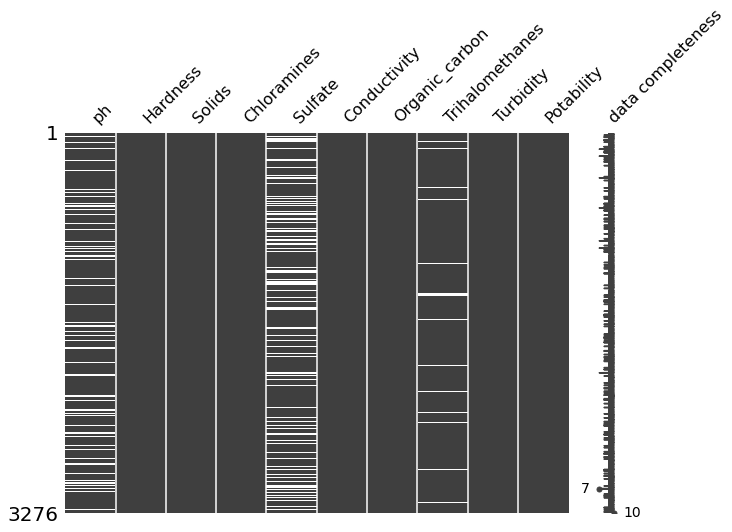

In [6]:
msno.matrix(water_data,figsize=(10,7),labels=True)

# Looking at the msno matrix below; ph,sulfate, and trihalomethanes contains missing values. The missing values are not related
#to each other and other observed data in the dataset
# so the missing values are definitely not MAR(missing at random)
# The missing values are MCAR(missing completely at random)

In [7]:
water_data.describe().T

#Basic exploratory data analysis
# Pretty much all the features are normally distributed

count     mean     std    min      25%      50%      75%  \
ph              2785.00     7.08    1.59   0.00     6.09     7.04     8.06   
Hardness        3276.00   196.37   32.88  47.43   176.85   196.97   216.67   
Solids          3276.00 22014.09 8768.57 320.94 15666.69 20927.83 27332.76   
Chloramines     3276.00     7.12    1.58   0.35     6.13     7.13     8.11   
Sulfate         2495.00   333.78   41.42 129.00   307.70   333.07   359.95   
Conductivity    3276.00   426.21   80.82 181.48   365.73   421.88   481.79   
Organic_carbon  3276.00    14.28    3.31   2.20    12.07    14.22    16.56   
Trihalomethanes 3114.00    66.40   16.18   0.74    55.84    66.62    77.34   
Turbidity       3276.00     3.97    0.78   1.45     3.44     3.96     4.50   
Potability      3276.00     0.39    0.49   0.00     0.00     0.00     1.00   

                     max  
ph                 14.00  
Hardness          323.12  
Solids          61227.20  
Chloramines        13.13  
Sulfate           481.03  
Conductivity      753.34  
Organic_carbon     28.30  
Trihalomethanes   124.00  
Turbidity           6.74  
Potability          1.00

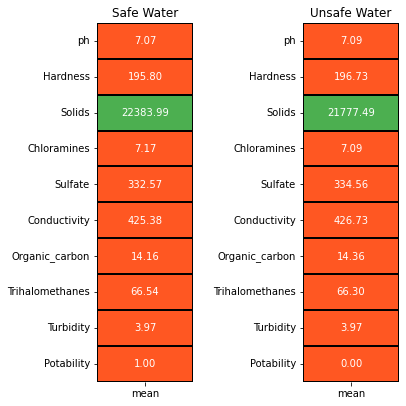

In [8]:
#To visualize the mean of each features in the dataset

water_yes = water_data[water_data['Potability']==1].describe().T
water_no = water_data[water_data['Potability']==0].describe().T

colours = ['#FF5722','#4CAF50']

fig, axes = plt.subplots(1,2,figsize=(6,6))
plt.subplot(1,2,1)
sns.heatmap(water_yes[['mean']], annot=True,cmap=colours,linewidths=0.4,linecolor='black',cbar=False,fmt='.2f')
plt.title('Safe Water')

plt.subplot(1,2,2)
sns.heatmap(water_no[['mean']], annot=True,cmap=colours,linewidths=0.4,linecolor='black',cbar=False,fmt='.2f')
plt.title('Unsafe Water');

fig.tight_layout(pad=2)


# Exploratory Data Analysis

In [9]:
cols = list(water_data.columns)
categorical_features = []
numerical_features = []
for feature in cols:
    if len(water_data[feature].unique()) > 6:
        numerical_features.append(feature)
    else:
        categorical_features.append(feature)

#print('Categorical Features :',*categorical_features)
#print('Numerical Features :',*numerical_features)

In [10]:
numerical_features1 = numerical_features[:4]
numerical_features2 = numerical_features[5:8]
numerical_features3 = ['ph','Conductivity', 'Organic_carbon', 'Trihalomethanes']

print(numerical_features1)
print(numerical_features2)

['ph', 'Hardness', 'Solids', 'Chloramines']
['Conductivity', 'Organic_carbon', 'Trihalomethanes']


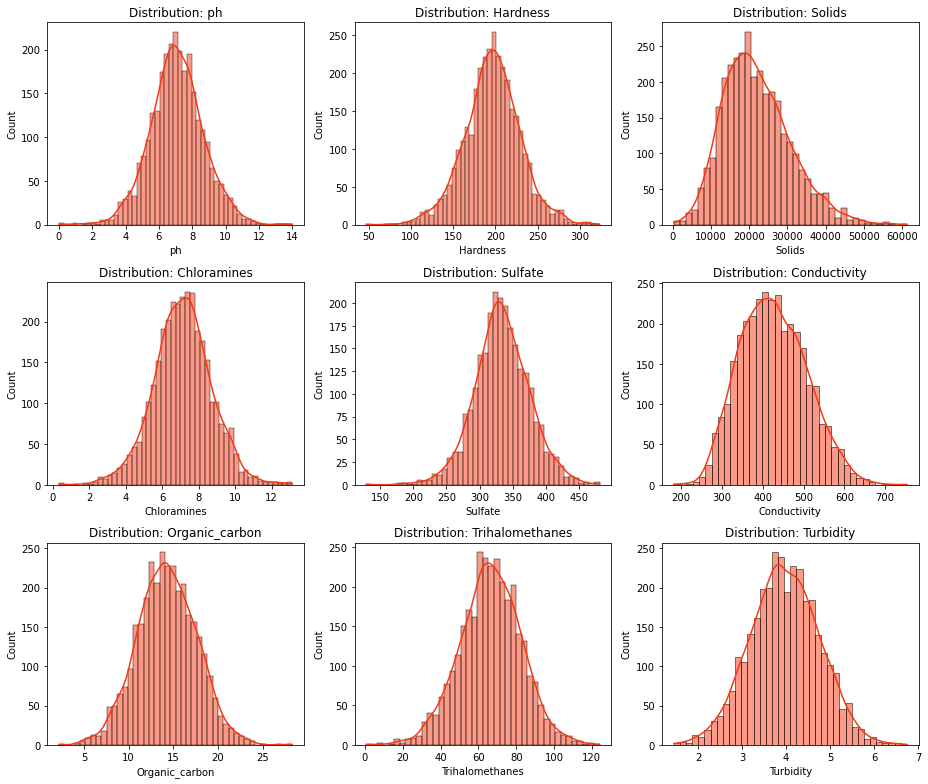

In [143]:
#Plots to show the distribution of the features in the dataset
hue_color = '#F93712'

fig, axes = plt.subplots(3, 3, figsize=(13, 11))

sns.histplot(water_data['ph'],kde=True,color=hue_color, ax=axes[0, 0])
axes[0, 0].set_xlabel('ph')
axes[0, 0].set_title('Distribution: ph')

sns.histplot(water_data['Hardness'],kde=True,color=hue_color, ax=axes[0, 1])
axes[0, 1].set_xlabel('Hardness')
axes[0, 1].set_title('Distribution: Hardness')

sns.histplot(water_data['Solids'],kde=True,color=hue_color, ax=axes[0, 2])
axes[0, 2].set_xlabel('Solids')
axes[0, 2].set_title('Distribution: Solids')

sns.histplot(water_data['Chloramines'],kde=True,color=hue_color, ax=axes[1, 0])
axes[1, 0].set_xlabel('Chloramines')
axes[1, 0].set_title('Distribution: Chloramines')

sns.histplot(water_data['Sulfate'],kde=True,color=hue_color, ax=axes[1, 1])
axes[1, 1].set_xlabel('Sulfate')
axes[1, 1].set_title('Distribution: Sulfate')

sns.histplot(water_data['Conductivity'],kde=True,color=hue_color, ax=axes[1, 2])
axes[1, 2].set_xlabel('Conductivity')
axes[1, 2].set_title('Distribution: Conductivity')

sns.histplot(water_data['Organic_carbon'],kde=True,color=hue_color, ax=axes[2, 0])
axes[2, 0].set_xlabel('Organic_carbon')
axes[2, 0].set_title('Distribution: Organic_carbon')

sns.histplot(water_data['Trihalomethanes'],kde=True,color=hue_color, ax=axes[2, 1])
axes[2, 1].set_xlabel('Trihalomethanes')
axes[2, 1].set_title('Distribution: Trihalomethanes')

sns.histplot(water_data['Turbidity'],kde=True,color=hue_color, ax=axes[2, 2])
axes[2, 2].set_xlabel('Turbidity')
axes[2, 2].set_title('Distribution: Turbidity')

plt.tight_layout()

# Pretty much all the features are normally distributed except the solids feature that is slightly skewed to the right

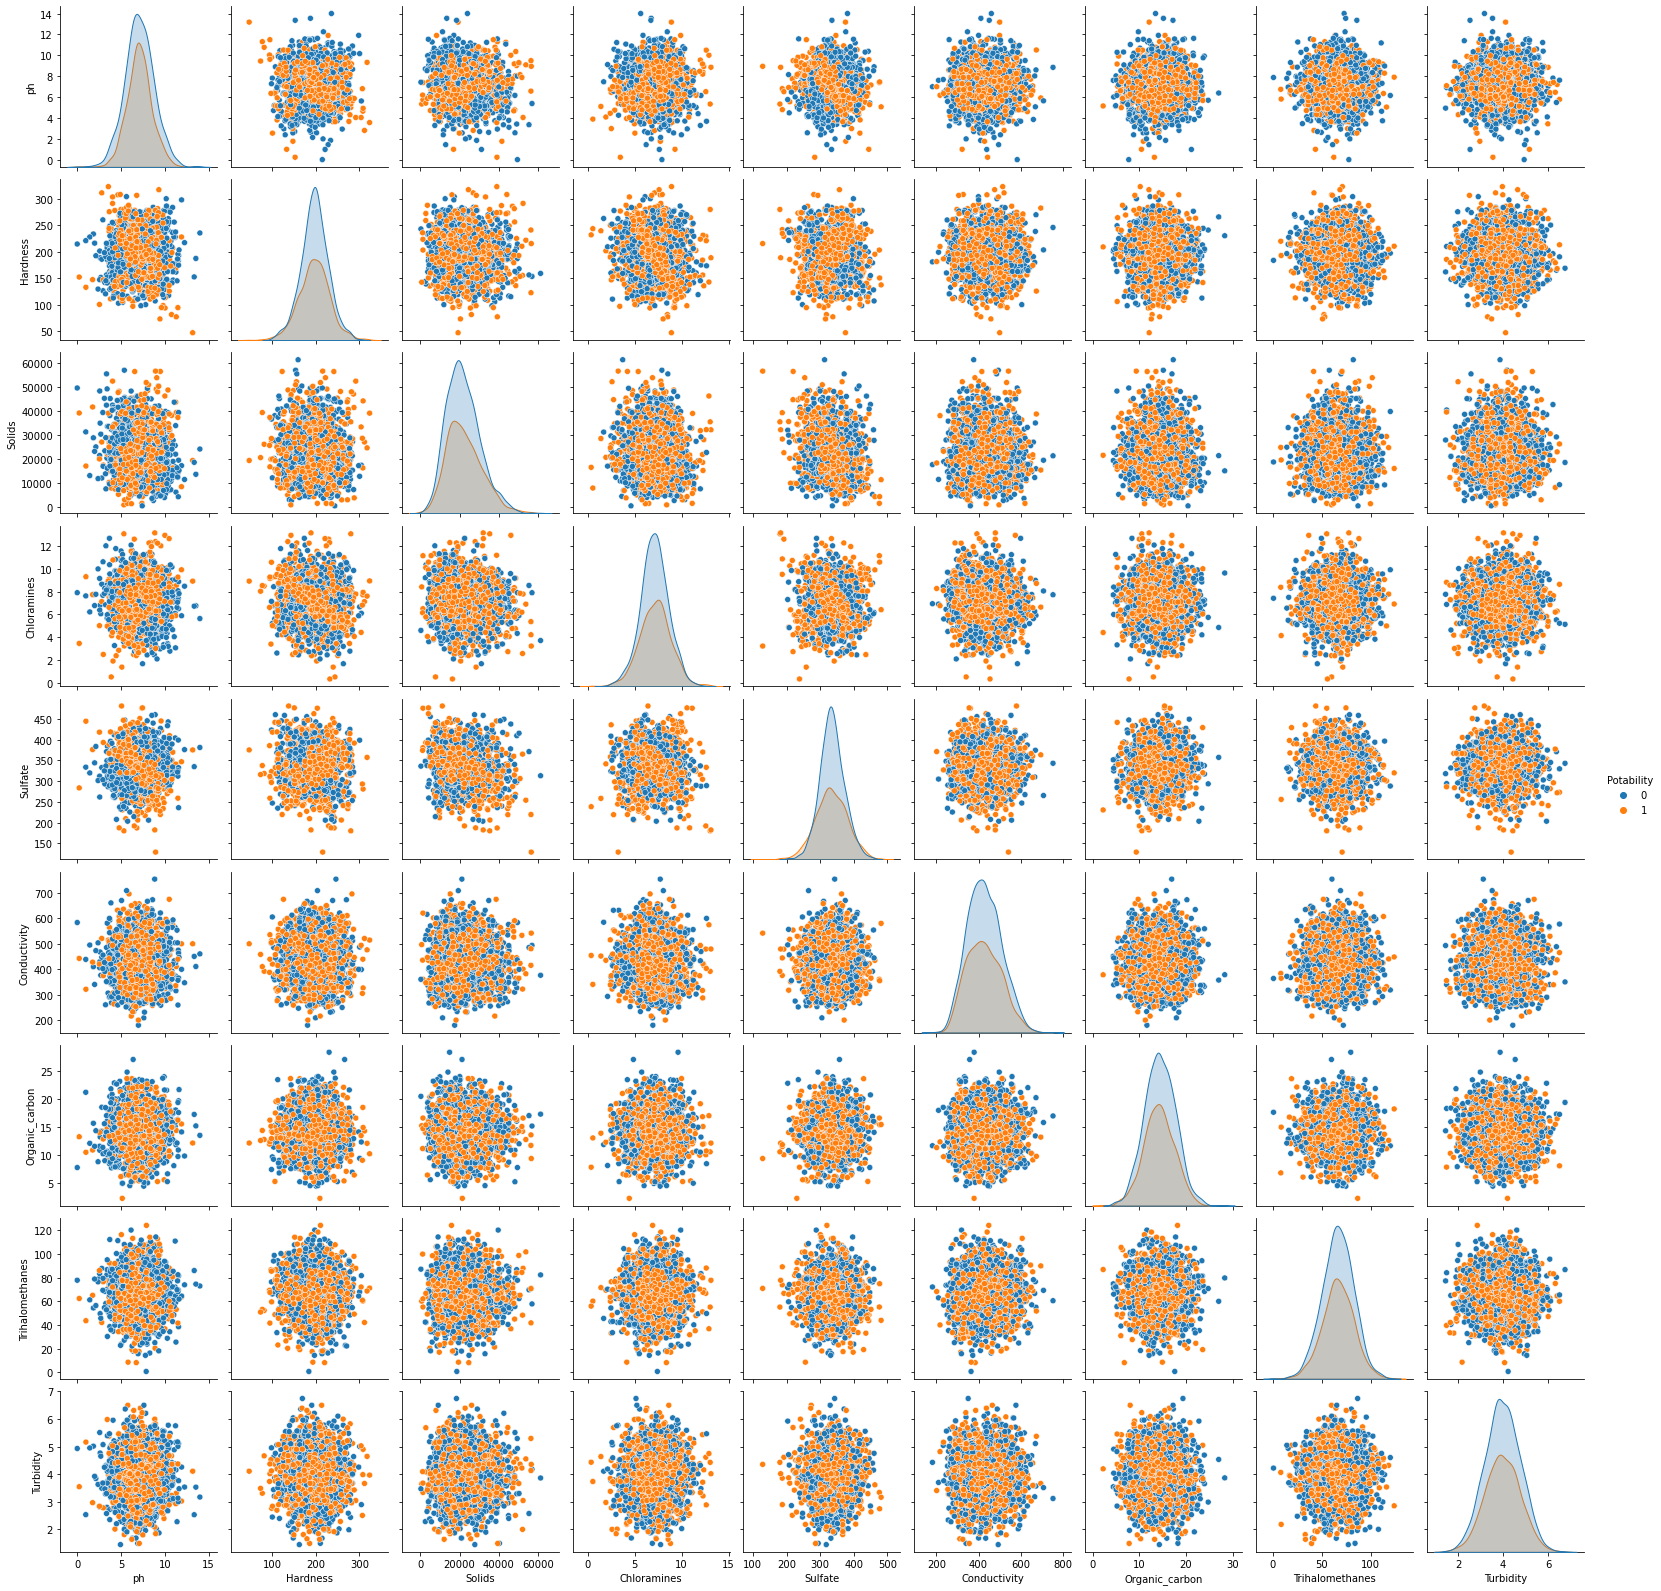

In [135]:
sns.pairplot(water_data,hue='Potability')

In [13]:
num_cols = water_data.skew(numeric_only=True)
num_cols

ph                 0.03
Hardness          -0.04
Solids             0.62
Chloramines       -0.01
Sulfate           -0.04
Conductivity       0.26
Organic_carbon     0.03
Trihalomethanes   -0.08
Turbidity         -0.01
Potability         0.45
dtype: float64

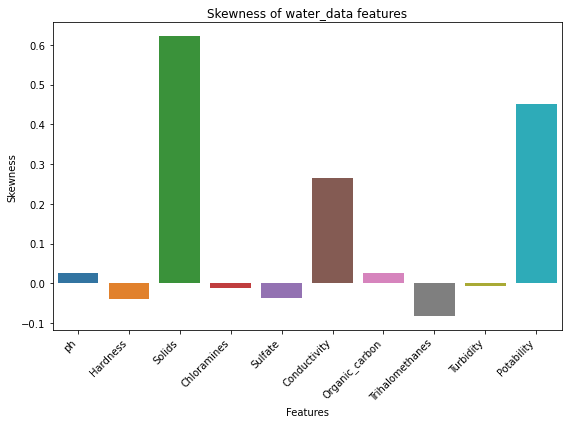

<Figure size 432x288 with 0 Axes>

In [133]:
plt.figure(figsize=(8, 6))
sns.barplot(x=num_cols.index, y=num_cols)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.title('Skewness of water_data features')
plt.tight_layout()
plt.show()

In [15]:
class_1 = (water_data['Potability']==1).sum()
class_0 = (water_data['Potability']==0).sum()
print(f"Class_1: {class_1}")
print(f"Class_0: {class_0}")

# There's an imbalance between the two classes present in the Potability feature

Class_1: 1278
Class_0: 1998


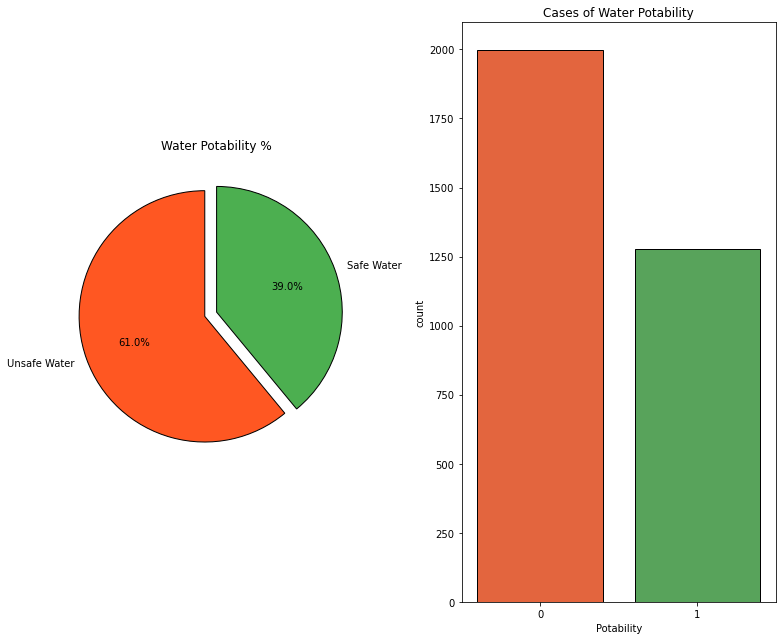

In [144]:
target_count = list(water_data['Potability'].value_counts())
circle = [target_count[0]/sum(target_count) * 100,target_count[1]/sum(target_count) * 100]

fig, ax = plt.subplots(1,2,figsize=(11,9))
plt.subplot(1,2,1)

plt.pie(circle,labels=['Unsafe Water','Safe Water'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colours,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Water Potability %')

plt.subplot(1,2,2)
sns.countplot('Potability',data = water_data,palette = colours,edgecolor = 'black')
plt.title('Cases of Water Potability');
plt.tight_layout()
#plt.show()

#From the visualization below, i could see that the class in water potability feature is imbalanced, it has more info on Unsafe 
# water than on Safe water. 
plt.savefig('C:/Users/CHUKS/Downloads/image5.png')

## Numerical Features vs Target(Water Potability)

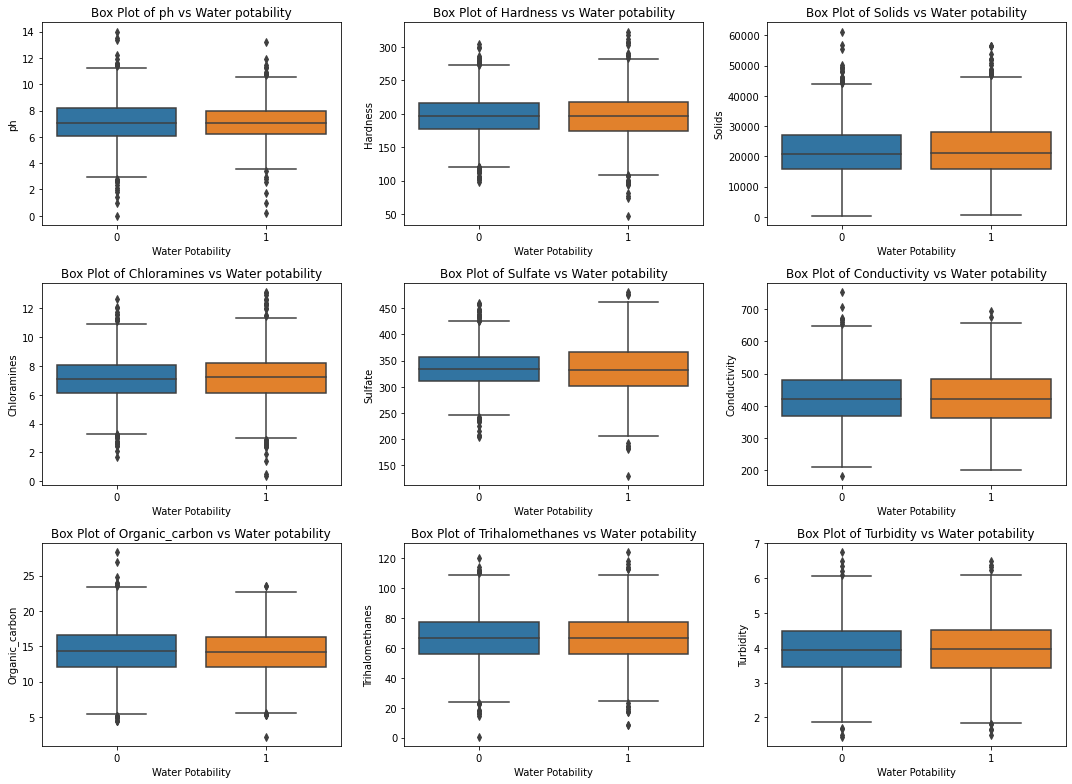

<Figure size 432x288 with 0 Axes>

In [137]:
fig,ax = plt.subplots(3,3,figsize=(15,11))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x='Potability', y=numerical_features[i], data=water_data)
    plt.title('Box Plot of' +" "+ numerical_features[i] + " " + 'vs Water potability')
    plt.xlabel('Water Potability')
    plt.ylabel(numerical_features[i])
    
plt.tight_layout()
plt.show()

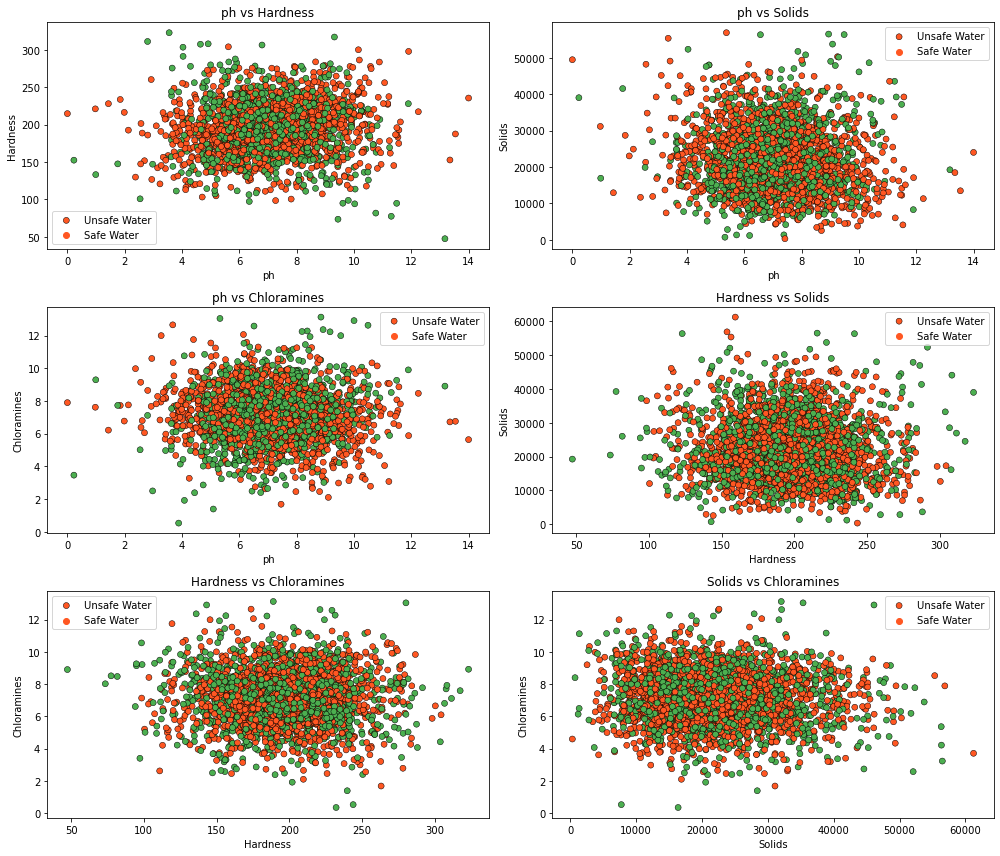

<Figure size 432x288 with 0 Axes>

In [138]:
a = 0
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 12)) 
for i in range(len(numerical_features1)):
    for j in range(len(numerical_features1)):
        if i != j and j > i:
            a += 1
            if a <= 6:  
                plt.subplot(3, 2, a)
                sns.scatterplot(x=numerical_features1[i], y=numerical_features1[j], data=water_data, hue='Potability', palette=colours, edgecolor='black')
                plt.legend(['Unsafe Water', 'Safe Water'])
                title = numerical_features1[i] + ' vs ' + numerical_features1[j]
                plt.title(title)

plt.tight_layout()  
plt.show()

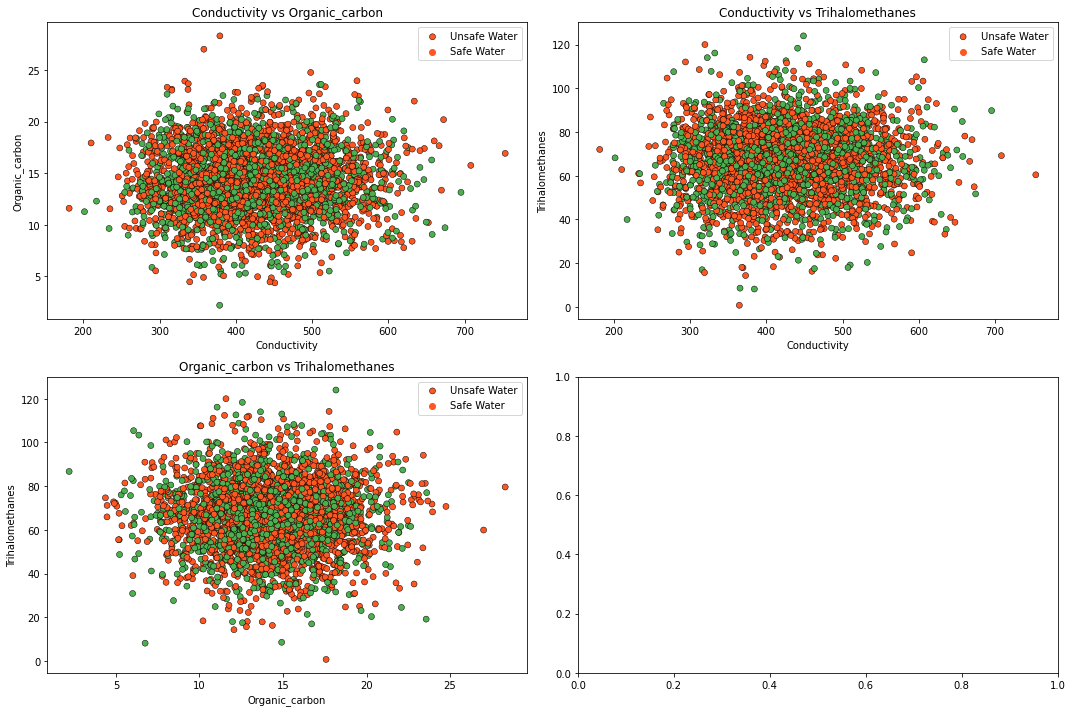

In [19]:
a = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))  # 3 rows and 2 columns for a total of 6 subplots

for i in range(len(numerical_features2)):
    for j in range(len(numerical_features2)):
        if i != j and j > i:
            a += 1
            if a <= 4:  
                plt.subplot(2, 2, a)
                sns.scatterplot(x=numerical_features2[i], y=numerical_features2[j], data=water_data, hue='Potability', palette=colours, edgecolor='black')
                plt.legend(['Unsafe Water', 'Safe Water'])
                title = numerical_features2[i] + ' vs ' + numerical_features2[j]
                plt.title(title)

plt.tight_layout()  
plt.show()

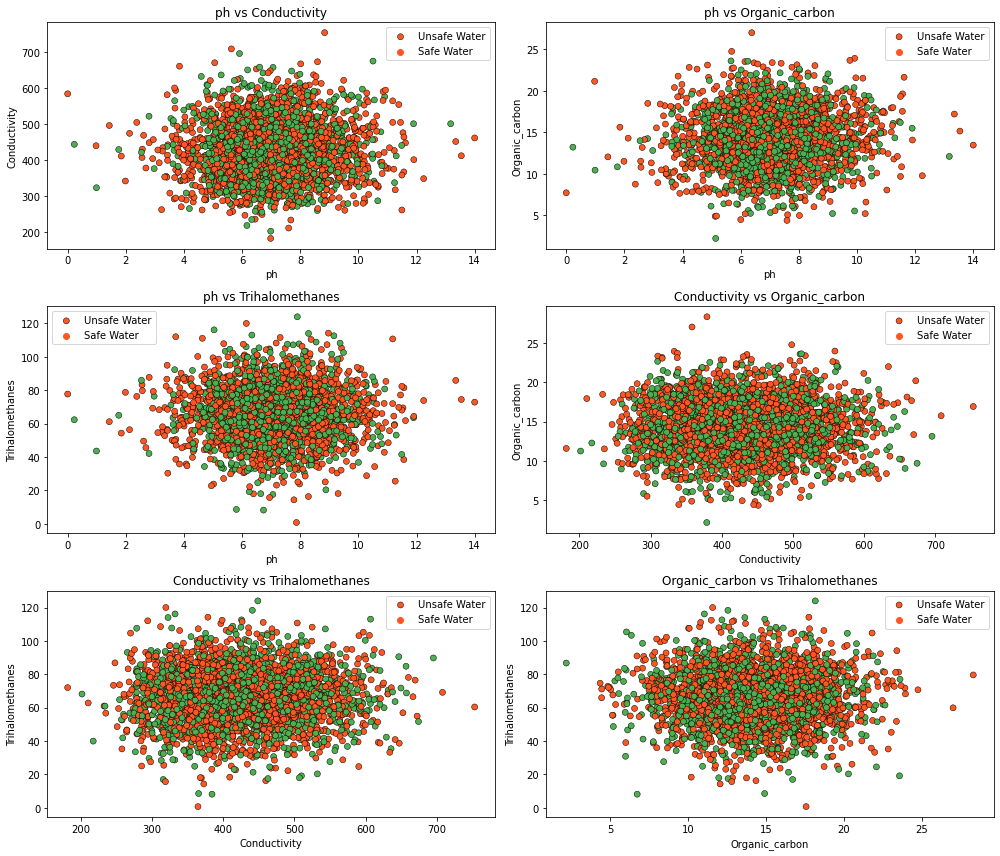

In [20]:
a = 0
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for i in range(len(numerical_features3)):
    for j in range(len(numerical_features3)):
        if i != j and j > i:
            a += 1
            if a <= 6:  
                plt.subplot(3, 2, a)
                sns.scatterplot(x=numerical_features3[i], y=numerical_features3[j], data=water_data, hue='Potability', palette=colours, edgecolor='black')
                plt.legend(['Unsafe Water', 'Safe Water'])
                title = numerical_features3[i] + ' vs ' + numerical_features3[j]
                plt.title(title)

plt.tight_layout()  
plt.show()


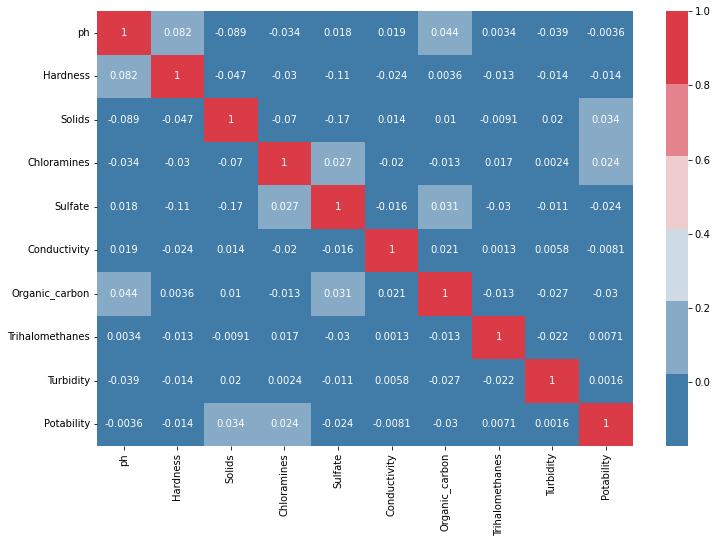

<Figure size 432x288 with 0 Axes>

In [139]:
plt.figure(figsize=(12,8))
sns.heatmap(data = water_data.corr(),annot=True, cbar=True,cmap=sns.diverging_palette(240,10))
plt.show()

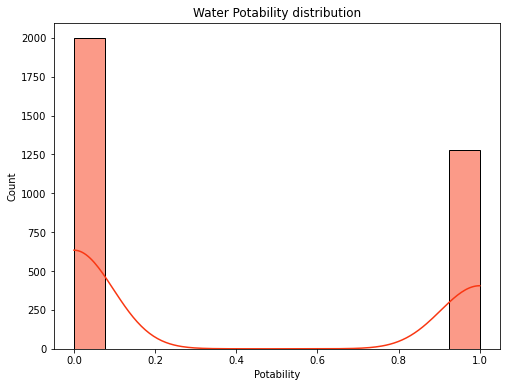

In [22]:
hue_color = '#F93712'

plt.figure(figsize=(8,6))
sns.histplot(data=water_data,x='Potability',kde=True,color=hue_color)
plt.title('Water Potability distribution')
plt.show()

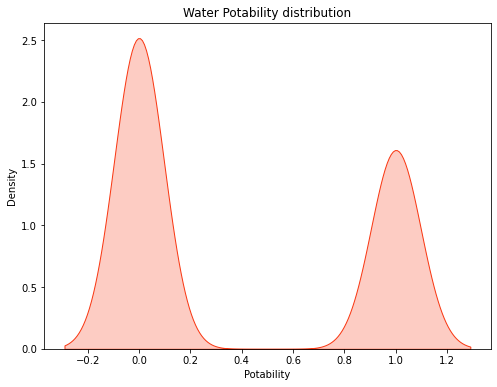

<Figure size 432x288 with 0 Axes>

In [140]:
hue_color = '#F93712'

plt.figure(figsize=(8,6))
sns.kdeplot(data=water_data,x='Potability',shade='fill',color=hue_color)
plt.title('Water Potability distribution')
plt.show()

# Data Preprocessing

In [24]:
water_data2 = copy.deepcopy(water_data)
water_data2.head()

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  Organic_carbon  \
0  NaN    204.89 20791.32         7.30   368.52        564.31           10.38   
1 3.72    129.42 18630.06         6.64      NaN        592.89           15.18   
2 8.10    224.24 19909.54         9.28      NaN        418.61           16.87   
3 8.32    214.37 22018.42         8.06   356.89        363.27           18.44   
4 9.09    181.10 17978.99         6.55   310.14        398.41           11.56   

   Trihalomethanes  Turbidity  Potability  
0            86.99       2.96           0  
1            56.33       4.50           0  
2            66.42       3.06           0  
3           100.34       4.63           0  
4            32.00       4.08           0

### Handling missing values

In [25]:
# The following features are normally distributed, fill missing values with the mean

ft_list = ['ph','Trihalomethanes','Sulfate']
ft_transform = SimpleImputer(strategy='mean')
water_data2[ft_list] = ft_transform.fit_transform(water_data2[ft_list])
water_data2

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    3.72    129.42 18630.06         6.64   333.78        592.89   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3271 4.67    193.68 47580.99         7.17   359.95        526.42   
3272 7.81    193.55 17329.80         8.06   333.78        392.45   
3273 9.42    175.76 33155.58         7.35   333.78        432.04   
3274 5.13    230.60 11983.87         6.30   333.78        402.88   
3275 7.87    195.10 17404.18         7.51   333.78        327.46   

      Organic_carbon  Trihalomethanes  Turbidity  Potability  
0              10.38            86.99       2.96           0  
1              15.18            56.33       4.50           0  
2              16.87            66.42       3.06           0  
3              18.44           100.34       4.63           0  
4              11.56            32.00       4.08           0  
...              ...              ...        ...         ...  
3271           13.89            66.69       4.44           1  
3272           19.90            66.40       2.80           1  
3273           11.04            69.85       3.30           1  
3274           11.17            77.49       4.71           1  
3275           16.14            78.70       2.31           1  

[3276 rows x 10 columns]

In [26]:
water_data2.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [27]:
y = water_data2['Potability'] #Assign target variable to y

In [28]:
water_data_train = water_data2.drop(['Potability'], axis=1)
water_data_train.head()

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  Organic_carbon  \
0 7.08    204.89 20791.32         7.30   368.52        564.31           10.38   
1 3.72    129.42 18630.06         6.64   333.78        592.89           15.18   
2 8.10    224.24 19909.54         9.28   333.78        418.61           16.87   
3 8.32    214.37 22018.42         8.06   356.89        363.27           18.44   
4 9.09    181.10 17978.99         6.55   310.14        398.41           11.56   

   Trihalomethanes  Turbidity  
0            86.99       2.96  
1            56.33       4.50  
2            66.42       3.06  
3           100.34       4.63  
4            32.00       4.08

### Handling class imbalance in the target variable

In [29]:
oversampler = RandomOverSampler(sampling_strategy='minority')
water_data_train_oversampled, y_oversampled = oversampler.fit_resample(water_data_train, y)

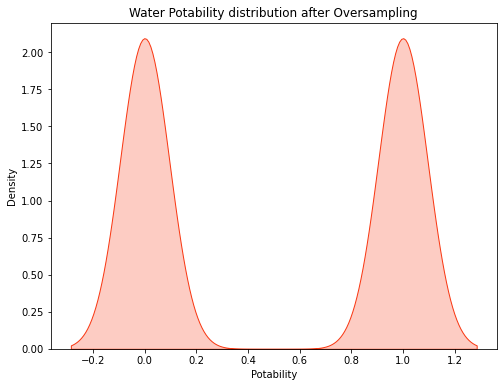

<Figure size 432x288 with 0 Axes>

In [141]:
hue_color = '#F93712'

plt.figure(figsize=(8, 6))
sns.kdeplot(data=y_oversampled, shade=True, color=hue_color)
plt.title('Water Potability distribution after Oversampling')
plt.xlabel('Potability')
plt.ylabel('Density')

plt.show()
plt.savefig('C:/Users/CHUKS/Downloads/Image10.png')

In [31]:
new_water_data = water_data_train_oversampled
new_y = y_oversampled
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    3.72    129.42 18630.06         6.64   333.78        592.89   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    266.48 34446.78         4.91   333.78        343.27   
3992 5.32    142.81   728.75         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.92    196.60 37215.23         7.41   247.93        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        649.81   

      Organic_carbon  Trihalomethanes  Turbidity  
0              10.38            86.99       2.96  
1              15.18            56.33       4.50  
2              16.87            66.42       3.06  
3              18.44           100.34       4.63  
4              11.56            32.00       4.08  
...              ...              ...        ...  
3991           14.26            64.96       3.74  
3992           15.17            60.08       3.65  
3993           11.29            58.24       3.71  
3994            5.51            77.83       3.39  
3995           10.26            71.78       3.03  

[3996 rows x 9 columns]

### Handling Outliers

In [32]:
# Applied winsorization to mitigate the effect of extreme outliers on the model

lower_percentile = 5
upper_percentile = 95

features_to_winsorize = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 
                         'Trihalomethanes', 'Turbidity']

for feature in features_to_winsorize:
    lower_limit = np.percentile(new_water_data[feature],lower_percentile)
    upper_limit = np.percentile(new_water_data[feature],upper_percentile)
    
    new_water_data[feature] = np.where(new_water_data[feature]<lower_limit,lower_limit,new_water_data[feature])
    new_water_data[feature] = np.where(new_water_data[feature]>upper_limit,upper_limit,new_water_data[feature])
    
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  
0              10.38            86.99       2.96  
1              15.18            56.33       4.50  
2              16.87            66.42       3.06  
3              18.44            91.59       4.63  
4              11.56            40.27       4.08  
...              ...              ...        ...  
3991           14.26            64.96       3.74  
3992           15.17            60.08       3.65  
3993           11.29            58.24       3.71  
3994            8.73            77.83       3.39  
3995           10.26            71.78       3.03  

[3996 rows x 9 columns]

### Feature Engineering

#### PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. 

In [33]:
new_water_data['ph_level'] = pd.cut(new_water_data['ph'],bins=[0,6.5,8.5,np.inf],labels=['acidic', 'neutral', 'alkaline'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level  
0              10.38            86.99       2.96   neutral  
1              15.18            56.33       4.50    acidic  
2              16.87            66.42       3.06   neutral  
3              18.44            91.59       4.63   neutral  
4              11.56            40.27       4.08  alkaline  
...              ...              ...        ...       ...  
3991           14.26            64.96       3.74  alkaline  
3992           15.17            60.08       3.65    acidic  
3993           11.29            58.24       3.71   neutral  
3994            8.73            77.83       3.39  alkaline  
3995           10.26            71.78       3.03    acidic  

[3996 rows x 10 columns]

#### Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness is caused by compounds of calcium and magnesium, and by a variety of other metals. General guidelines for classification of waters are: 0 to 60 mg/L (milligrams per liter) as calcium carbonate is classified as soft; 61 to 120 mg/L as moderately hard; 121 to 180 mg/L as hard; and more than 180 mg/L as very hard.

In [34]:
threshold1 = 60
threshold2 = 120
threshold3 = 180

new_water_data['Hardness_level'] = pd.cut(new_water_data['Hardness'],bins=[0,threshold1,threshold2,threshold3,np.inf],labels=['low','medium','high','very high'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  
0              10.38            86.99       2.96   neutral      very high  
1              15.18            56.33       4.50    acidic           high  
2              16.87            66.42       3.06   neutral      very high  
3              18.44            91.59       4.63   neutral      very high  
4              11.56            40.27       4.08  alkaline      very high  
...              ...              ...        ...       ...            ...  
3991           14.26            64.96       3.74  alkaline      very high  
3992           15.17            60.08       3.65    acidic           high  
3993           11.29            58.24       3.71   neutral           high  
3994            8.73            77.83       3.39  alkaline      very high  
3995           10.26            71.78       3.03    acidic      very high  

[3996 rows x 11 columns]

#### Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.


In [35]:
new_water_data['TDS_level'] = pd.cut(new_water_data['Solids'],bins=[0,500,1000,np.inf],labels=['low','average','high'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level  
0         high  
1         high  
2         high  
3         high  
4         high  
...        ...  
3991      high  
3992      high  
3993      high  
3994      high  
3995      high  

[3996 rows x 12 columns]

#### Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

In [36]:
new_water_data['Chloramines_level'] = pd.cut(new_water_data['Chloramines'],bins=[0,4,np.inf],labels=['safe','unsafe'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level  
0         high            unsafe  
1         high            unsafe  
2         high            unsafe  
3         high            unsafe  
4         high            unsafe  
...        ...               ...  
3991      high            unsafe  
3992      high            unsafe  
3993      high            unsafe  
3994      high            unsafe  
3995      high            unsafe  

[3996 rows x 13 columns]

#### Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The drinking standards laid down by the WHO are 250 mg/L of sulfates and the maximum admissible concentration can reach 400 mg/L.

In [37]:
new_water_data['Sulfate_level'] = pd.cut(new_water_data['Sulfate'],bins=[0,250,400,np.inf],labels=['low','medium','high'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level Sulfate_level  
0         high            unsafe        medium  
1         high            unsafe        medium  
2         high            unsafe        medium  
3         high            unsafe        medium  
4         high            unsafe        medium  
...        ...               ...           ...  
3991      high            unsafe        medium  
3992      high            unsafe        medium  
3993      high            unsafe        medium  
3994      high            unsafe        medium  
3995      high            unsafe        medium  

[3996 rows x 14 columns]

#### Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

In [38]:
new_water_data['Conductivity_Level'] = pd.cut(new_water_data['Conductivity'], bins=[0, 400, np.inf], labels=['low', 'high'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level Sulfate_level Conductivity_Level  
0         high            unsafe        medium               high  
1         high            unsafe        medium               high  
2         high            unsafe        medium               high  
3         high            unsafe        medium                low  
4         high            unsafe        medium                low  
...        ...               ...           ...                ...  
3991      high            unsafe        medium                low  
3992      high            unsafe        medium               high  
3993      high            unsafe        medium               high  
3994      high            unsafe        medium               high  
3995      high            unsafe        medium               high  

[3996 rows x 15 columns]

#### Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.


In [39]:
new_water_data['Organic_Carbon_Level'] = pd.cut(new_water_data['Organic_carbon'], bins=[0, 2, 4, np.inf], labels=['safe','fairly safe','unsafe'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level Sulfate_level Conductivity_Level  \
0         high            unsafe        medium               high   
1         high            unsafe        medium               high   
2         high            unsafe        medium               high   
3         high            unsafe        medium                low   
4         high            unsafe        medium                low   
...        ...               ...           ...                ...   
3991      high            unsafe        medium                low   
3992      high            unsafe        medium               high   
3993      high            unsafe        medium               high   
3994      high            unsafe        medium               high   
3995      high            unsafe        medium               high   

     Organic_Carbon_Level  
0                  unsafe  
1                  unsafe  
2                  unsafe  
3                  unsafe  
4                  unsafe  
...                   ...  
3991               unsafe  
3992               unsafe  
3993               unsafe  
3994               unsafe  
3995               unsafe  

[3996 rows x 16 columns]

#### THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.


In [40]:
new_water_data['Trihalomethanes_level'] = pd.cut(new_water_data['Trihalomethanes'],bins=[0,80,np.inf],labels=['safe','unsafe'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level Sulfate_level Conductivity_Level  \
0         high            unsafe        medium               high   
1         high            unsafe        medium               high   
2         high            unsafe        medium               high   
3         high            unsafe        medium                low   
4         high            unsafe        medium                low   
...        ...               ...           ...                ...   
3991      high            unsafe        medium                low   
3992      high            unsafe        medium               high   
3993      high            unsafe        medium               high   
3994      high            unsafe        medium               high   
3995      high            unsafe        medium               high   

     Organic_Carbon_Level Trihalomethanes_level  
0                  unsafe                unsafe  
1                  unsafe                  safe  
2                  unsafe                  safe  
3                  unsafe                unsafe  
4                  unsafe                  safe  
...                   ...                   ...  
3991               unsafe                  safe  
3992               unsafe                  safe  
3993               unsafe                  safe  
3994               unsafe                  safe  
3995               unsafe                  safe  

[3996 rows x 17 columns]

#### The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.


In [41]:
new_water_data['Turbidity_Level'] = pd.cut(new_water_data['Turbidity'], bins=[0, 5, np.inf], labels=['low', 'high'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level Hardness_level  \
0              10.38            86.99       2.96   neutral      very high   
1              15.18            56.33       4.50    acidic           high   
2              16.87            66.42       3.06   neutral      very high   
3              18.44            91.59       4.63   neutral      very high   
4              11.56            40.27       4.08  alkaline      very high   
...              ...              ...        ...       ...            ...   
3991           14.26            64.96       3.74  alkaline      very high   
3992           15.17            60.08       3.65    acidic           high   
3993           11.29            58.24       3.71   neutral           high   
3994            8.73            77.83       3.39  alkaline      very high   
3995           10.26            71.78       3.03    acidic      very high   

     TDS_level Chloramines_level Sulfate_level Conductivity_Level  \
0         high            unsafe        medium               high   
1         high            unsafe        medium               high   
2         high            unsafe        medium               high   
3         high            unsafe        medium                low   
4         high            unsafe        medium                low   
...        ...               ...           ...                ...   
3991      high            unsafe        medium                low   
3992      high            unsafe        medium               high   
3993      high            unsafe        medium               high   
3994      high            unsafe        medium               high   
3995      high            unsafe        medium               high   

     Organic_Carbon_Level Trihalomethanes_level Turbidity_Level  
0                  unsafe                unsafe             low  
1                  unsafe                  safe             low  
2                  unsafe                  safe             low  
3                  unsafe                unsafe             low  
4                  unsafe                  safe             low  
...                   ...                   ...             ...  
3991               unsafe                  safe             low  
3992               unsafe                  safe             low  
3993               unsafe                  safe             low  
3994               unsafe                  safe             low  
3995               unsafe                  safe             low  

[3996 rows x 18 columns]

### Encoding Categorical Features

In [42]:
label_encoder = LabelEncoder()
#features_to_encode = ['ph_category','TDS_level','Chloramines_level','Organic_Carbon_Level','Trihalomethanes_level']
new_water_data['ph_level_encoded'] = label_encoder.fit_transform(new_water_data['ph_level'])
new_water_data['TDS_level_encoded'] = label_encoder.fit_transform(new_water_data['TDS_level'])
new_water_data['Chloramines_level_encoded'] = label_encoder.fit_transform(new_water_data['Chloramines_level'])
new_water_data['Organic_level_encoded'] = label_encoder.fit_transform(new_water_data['Organic_Carbon_Level'])
new_water_data['Trihalomethanes_level_encoded'] = label_encoder.fit_transform(new_water_data['Trihalomethanes_level'])
new_water_data['Sulfate_level_encoded'] = label_encoder.fit_transform(new_water_data['Sulfate_level'])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level  ...  \
0              10.38            86.99       2.96   neutral  ...   
1              15.18            56.33       4.50    acidic  ...   
2              16.87            66.42       3.06   neutral  ...   
3              18.44            91.59       4.63   neutral  ...   
4              11.56            40.27       4.08  alkaline  ...   
...              ...              ...        ...       ...  ...   
3991           14.26            64.96       3.74  alkaline  ...   
3992           15.17            60.08       3.65    acidic  ...   
3993           11.29            58.24       3.71   neutral  ...   
3994            8.73            77.83       3.39  alkaline  ...   
3995           10.26            71.78       3.03    acidic  ...   

     Conductivity_Level Organic_Carbon_Level Trihalomethanes_level  \
0                  high               unsafe                unsafe   
1                  high               unsafe                  safe   
2                  high               unsafe                  safe   
3                   low               unsafe                unsafe   
4                   low               unsafe                  safe   
...                 ...                  ...                   ...   
3991                low               unsafe                  safe   
3992               high               unsafe                  safe   
3993               high               unsafe                  safe   
3994               high               unsafe                  safe   
3995               high               unsafe                  safe   

     Turbidity_Level ph_level_encoded TDS_level_encoded  \
0                low                2                 0   
1                low                0                 0   
2                low                2                 0   
3                low                2                 0   
4                low                1                 0   
...              ...              ...               ...   
3991             low                1                 0   
3992             low                0                 0   
3993             low                2                 0   
3994             low                1                 0   
3995             low                0                 0   

     Chloramines_level_encoded Organic_level_encoded  \
0                            0                     0   
1                            0                     0   
2                            0                     0   
3                            0                     0   
4                            0                     0   
...                        ...                   ...   
3991                         0                     0   
3992                         0                     0   
3993                         0                     0   
3994                         0                     0   
3995                         0                     0   

      Trihalomethanes_level_encoded  Sulfate_level_encoded  
0                                 1                      0  
1                                 0     

In [43]:
ordinal_encoder = OrdinalEncoder()
new_water_data['Conductivity_level_encoded'] = ordinal_encoder.fit_transform(new_water_data[['Conductivity_Level']])
new_water_data['Turbity_level_encoded'] = ordinal_encoder.fit_transform(new_water_data[['Turbidity_Level']])
new_water_data['Hardness_level_encoded'] = ordinal_encoder.fit_transform(new_water_data[['Hardness_level']])
new_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level  ...  \
0              10.38            86.99       2.96   neutral  ...   
1              15.18            56.33       4.50    acidic  ...   
2              16.87            66.42       3.06   neutral  ...   
3              18.44            91.59       4.63   neutral  ...   
4              11.56            40.27       4.08  alkaline  ...   
...              ...              ...        ...       ...  ...   
3991           14.26            64.96       3.74  alkaline  ...   
3992           15.17            60.08       3.65    acidic  ...   
3993           11.29            58.24       3.71   neutral  ...   
3994            8.73            77.83       3.39  alkaline  ...   
3995           10.26            71.78       3.03    acidic  ...   

     Turbidity_Level ph_level_encoded TDS_level_encoded  \
0                low                2                 0   
1                low                0                 0   
2                low                2                 0   
3                low                2                 0   
4                low                1                 0   
...              ...              ...               ...   
3991             low                1                 0   
3992             low                0                 0   
3993             low                2                 0   
3994             low                1                 0   
3995             low                0                 0   

     Chloramines_level_encoded Organic_level_encoded  \
0                            0                     0   
1                            0                     0   
2                            0                     0   
3                            0                     0   
4                            0                     0   
...                        ...                   ...   
3991                         0                     0   
3992                         0                     0   
3993                         0                     0   
3994                         0                     0   
3995                         0                     0   

     Trihalomethanes_level_encoded Sulfate_level_encoded  \
0                                1                     0   
1                                0                     0   
2                                0                     0   
3                                1                     0   
4                                0                     0   
...                            ...                   ...   
3991                             0                     0   
3992                             0                     0   
3993                             0                     0   
3994                             0                     0   
3995                             0                     0   

     Conductivity_level_encoded  Turbity_level_encoded  Hardness_level_encoded  
0                          0.00                   1.00                    1.00  
1                          0.00                   1.00                    0.00  
2                          0.00        

#### Drop categorical features

In [44]:
features_to_drop = ['ph_level','Hardness_level','TDS_level','Chloramines_level','Sulfate_level','Conductivity_Level',
                    'Organic_Carbon_Level','Trihalomethanes_level','Turbidity_Level']
final_water_data = new_water_data.drop(features_to_drop,axis=1)
final_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level_encoded  \
0              10.38            86.99       2.96                 2   
1              15.18            56.33       4.50                 0   
2              16.87            66.42       3.06                 2   
3              18.44            91.59       4.63                 2   
4              11.56            40.27       4.08                 1   
...              ...              ...        ...               ...   
3991           14.26            64.96       3.74                 1   
3992           15.17            60.08       3.65                 0   
3993           11.29            58.24       3.71                 2   
3994            8.73            77.83       3.39                 1   
3995           10.26            71.78       3.03                 0   

      TDS_level_encoded  Chloramines_level_encoded  Organic_level_encoded  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          0                      0   
3                     0                          0                      0   
4                     0                          0                      0   
...                 ...                        ...                    ...   
3991                  0                          0                      0   
3992                  0                          0                      0   
3993                  0                          0                      0   
3994                  0                          0                      0   
3995                  0                          0                      0   

      Trihalomethanes_level_encoded  Sulfate_level_encoded  \
0                                 1                      0   
1                                 0                      0   
2                                 0                      0   
3                                 1                      0   
4                                 0                      0   
...                             ...                    ...   
3991                              0                      0   
3992                              0                      0   
3993                              0                      0   
3994                              0                      0   
3995                              0                      0   

      Conductivity_level_encoded  Turbity_level_encoded  \
0                           0.00                   1.00   
1                           0.00                   1.00   
2                           0.00                   1.00   
3                           1.00                   1.00   
4                           1.00                   1.00   
...                          ...                    ...   
3991                        1.00                   1.00   
3992                        0.00                   1.00   
3993                        0.00                   1.00   
3994                        0.00                   1.00   
3995                        0.

In [45]:
final_water_data

ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0    7.08    204.89 20791.32         7.30   368.52        564.31   
1    4.74    139.94 18630.06         6.64   333.78        566.35   
2    8.10    224.24 19909.54         9.28   333.78        418.61   
3    8.32    214.37 22018.42         8.06   356.89        363.27   
4    9.09    181.10 17978.99         6.55   310.14        398.41   
...   ...       ...      ...          ...      ...           ...   
3991 8.97    249.54 34446.78         4.91   333.78        343.27   
3992 5.32    142.81  9492.84         8.40   333.78        497.00   
3993 7.47    177.23 15736.58         6.88   277.11        401.62   
3994 9.60    196.60 37215.23         7.41   273.03        522.55   
3995 6.19    224.43 15229.70         5.88   366.50        566.35   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level_encoded  \
0              10.38            86.99       2.96                 2   
1              15.18            56.33       4.50                 0   
2              16.87            66.42       3.06                 2   
3              18.44            91.59       4.63                 2   
4              11.56            40.27       4.08                 1   
...              ...              ...        ...               ...   
3991           14.26            64.96       3.74                 1   
3992           15.17            60.08       3.65                 0   
3993           11.29            58.24       3.71                 2   
3994            8.73            77.83       3.39                 1   
3995           10.26            71.78       3.03                 0   

      TDS_level_encoded  Chloramines_level_encoded  Organic_level_encoded  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          0                      0   
3                     0                          0                      0   
4                     0                          0                      0   
...                 ...                        ...                    ...   
3991                  0                          0                      0   
3992                  0                          0                      0   
3993                  0                          0                      0   
3994                  0                          0                      0   
3995                  0                          0                      0   

      Trihalomethanes_level_encoded  Sulfate_level_encoded  \
0                                 1                      0   
1                                 0                      0   
2                                 0                      0   
3                                 1                      0   
4                                 0                      0   
...                             ...                    ...   
3991                              0                      0   
3992                              0                      0   
3993                              0                      0   
3994                              0                      0   
3995                              0                      0   

      Conductivity_level_encoded  Turbity_level_encoded  \
0                           0.00                   1.00   
1                           0.00                   1.00   
2                           0.00                   1.00   
3                           1.00                   1.00   
4                           1.00                   1.00   
...                          ...                    ...   
3991                        1.00                   1.00   
3992                        0.00                   1.00   
3993                        0.00                   1.00   
3994                        0.00                   1.00   
3995                        0.

### Feature Scaling

In [46]:
scaler = StandardScaler()
features_to_scale = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
                    'Organic_carbon', 'Trihalomethanes', 'Turbidity']
scaled_features = scaler.fit_transform(new_water_data[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features,columns= features_to_scale)
final_water_data[features_to_scale] = scaled_features_df
final_water_data

ph  Hardness  Solids  Chloramines  Sulfate  Conductivity  \
0    -0.00      0.30   -0.13         0.10     1.08          1.84   
1    -1.87     -1.91   -0.40        -0.37    -0.01          1.87   
2     0.81      0.96   -0.24         1.49    -0.01         -0.10   
3     0.98      0.63    0.03         0.64     0.71         -0.83   
4     1.59     -0.51   -0.48        -0.43    -0.74         -0.36   
...    ...       ...     ...          ...      ...           ...   
3991  1.49      1.82    1.60        -1.58    -0.01         -1.10   
3992 -1.40     -1.81   -1.55         0.88    -0.01          0.95   
3993  0.31     -0.64   -0.77        -0.20    -1.77         -0.32   
3994  2.00      0.02    1.94         0.18    -1.90          1.29   
3995 -0.71      0.97   -0.83        -0.90     1.01          1.87   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level_encoded  \
0              -1.28             1.48      -1.40                 2   
1               0.32            -0.72       0.74                 0   
2               0.88             0.00      -1.28                 2   
3               1.40             1.81       0.92                 2   
4              -0.89            -1.88       0.15                 1   
...              ...              ...        ...               ...   
3991            0.01            -0.10      -0.32                 1   
3992            0.31            -0.45      -0.44                 0   
3993           -0.98            -0.58      -0.36                 2   
3994           -1.83             0.82      -0.80                 1   
3995           -1.32             0.39      -1.32                 0   

      TDS_level_encoded  Chloramines_level_encoded  Organic_level_encoded  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          0                      0   
3                     0                          0                      0   
4                     0                          0                      0   
...                 ...                        ...                    ...   
3991                  0                          0                      0   
3992                  0                          0                      0   
3993                  0                          0                      0   
3994                  0                          0                      0   
3995                  0                          0                      0   

      Trihalomethanes_level_encoded  Sulfate_level_encoded  \
0                                 1                      0   
1                                 0                      0   
2                                 0                      0   
3                                 1                      0   
4                                 0                      0   
...                             ...                    ...   
3991                              0                      0   
3992                              0                      0   
3993                              0                      0   
3994                              0                      0   
3995                              0                      0   

      Conductivity_level_encoded  Turbity_level_encoded  \
0                           0.00                   1.00   
1                           0.00                   1.00   
2                           0.00                   1.00   
3                           1.00                   1.00   
4                           1.00                   1.00   
...                          ...                    ...   
3991                        1.00                   1.00   
3992                        0.00                   1.00   
3993                        0.00                   1.00   
3994                        0.00                   1.00   
3995                        0.0

In [47]:
Train = final_water_data
Train

ph  Hardness  Solids  Chloramines  Sulfate  Conductivity  \
0    -0.00      0.30   -0.13         0.10     1.08          1.84   
1    -1.87     -1.91   -0.40        -0.37    -0.01          1.87   
2     0.81      0.96   -0.24         1.49    -0.01         -0.10   
3     0.98      0.63    0.03         0.64     0.71         -0.83   
4     1.59     -0.51   -0.48        -0.43    -0.74         -0.36   
...    ...       ...     ...          ...      ...           ...   
3991  1.49      1.82    1.60        -1.58    -0.01         -1.10   
3992 -1.40     -1.81   -1.55         0.88    -0.01          0.95   
3993  0.31     -0.64   -0.77        -0.20    -1.77         -0.32   
3994  2.00      0.02    1.94         0.18    -1.90          1.29   
3995 -0.71      0.97   -0.83        -0.90     1.01          1.87   

      Organic_carbon  Trihalomethanes  Turbidity  ph_level_encoded  \
0              -1.28             1.48      -1.40                 2   
1               0.32            -0.72       0.74                 0   
2               0.88             0.00      -1.28                 2   
3               1.40             1.81       0.92                 2   
4              -0.89            -1.88       0.15                 1   
...              ...              ...        ...               ...   
3991            0.01            -0.10      -0.32                 1   
3992            0.31            -0.45      -0.44                 0   
3993           -0.98            -0.58      -0.36                 2   
3994           -1.83             0.82      -0.80                 1   
3995           -1.32             0.39      -1.32                 0   

      TDS_level_encoded  Chloramines_level_encoded  Organic_level_encoded  \
0                     0                          0                      0   
1                     0                          0                      0   
2                     0                          0                      0   
3                     0                          0                      0   
4                     0                          0                      0   
...                 ...                        ...                    ...   
3991                  0                          0                      0   
3992                  0                          0                      0   
3993                  0                          0                      0   
3994                  0                          0                      0   
3995                  0                          0                      0   

      Trihalomethanes_level_encoded  Sulfate_level_encoded  \
0                                 1                      0   
1                                 0                      0   
2                                 0                      0   
3                                 1                      0   
4                                 0                      0   
...                             ...                    ...   
3991                              0                      0   
3992                              0                      0   
3993                              0                      0   
3994                              0                      0   
3995                              0                      0   

      Conductivity_level_encoded  Turbity_level_encoded  \
0                           0.00                   1.00   
1                           0.00                   1.00   
2                           0.00                   1.00   
3                           1.00                   1.00   
4                           1.00                   1.00   
...                          ...                    ...   
3991                        1.00                   1.00   
3992                        0.00                   1.00   
3993                        0.00                   1.00   
3994                        0.00                   1.00   
3995                        0.0

In [81]:
X_train, X_test, y_train, y_test = train_test_split(Train,new_y,test_size=0.1,random_state=5)

In [82]:
y_train

569     0
3234    1
2588    0
1067    0
1615    1
       ..
3190    1
3046    0
1725    0
2254    0
2915    0
Name: Potability, Length: 3596, dtype: int64

In [83]:
X_train.shape

(3596, 18)

### Training the Model

In [84]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

#### Random Forest

In [85]:
rf_model = RandomForestClassifier()

In [53]:
rf_param_dist = {
    'n_estimators': range(100,1000),
    'max_depth': range(5,500),
    'min_samples_split': range(2, 10), 
    'min_samples_leaf': range(2, 10),
}

In [54]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    rf_random_search=RandomizedSearchCV(rf_model,param_distributions=rf_param_dist,n_iter=10,scoring='accuracy')
    rf_random_search.fit(train_x,train_y)
rf_params = rf_random_search.best_params_
rf_params

{'n_estimators': 926,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 407}

In [87]:
acc_scores = []

for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    
    rf_model = RandomForestClassifier(n_estimators=832,min_samples_split=5,min_samples_leaf=3,max_depth=125,random_state=5)
    
    rf_model.fit(train_x,train_y)
    
    rf_target_pred = rf_model.predict(test_x)
    score = accuracy_score(test_y,rf_target_pred)
    acc_scores.append(score)

acc_scores
mean_score = np.mean(acc_scores)
mean_score

0.7575135218667903

In [88]:
prec_score = precision_score(test_y,rf_target_pred)
prec_score

0.7808988764044944

In [89]:
confusion_matrix(test_y,rf_target_pred)

array([[278,  78],
       [ 85, 278]], dtype=int64)

#### Logistic Regression

In [90]:
lgr_model = LogisticRegression()

In [149]:
# hyper-parameter tuning
lgr_param_dist = {
    'penalty':['l1','l2'],
    'C': np.linspace(0.001,200,num=30),
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': [None, 'balanced'],
    'tol': np.linspace(1e-4,1,num=30)}

In [60]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    lgr_random_search=RandomizedSearchCV(lgr_model,param_distributions=lgr_param_dist,n_iter=10,scoring='accuracy')
    lgr_random_search.fit(train_x,train_y)
lgr_params = lgr_random_search.best_params_
lgr_params'''

{'tol': 0.7241655172413793,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'multi_class': 'multinomial',
 'class_weight': 'balanced',
 'C': 158.62089655172414}

In [91]:
acc_scores = []

for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    
    lr_model = LogisticRegression(C=82.75920689655173,class_weight='balanced',multi_class='multinomial',penalty='l2',
                               solver='saga',tol=0.8276034482758621, random_state=5)
    
    lr_model.fit(train_x,train_y)
    
    lr_target_pred = lr_model.predict(test_x)
    score = accuracy_score(test_y,lr_target_pred)
    acc_scores.append(score)

acc_scores
mean_score = np.mean(acc_scores)
mean_score

0.5108379694019471

In [92]:
prec_score = precision_score(test_y,lr_target_pred)
prec_score

0.465625

In [93]:
confusion_matrix(test_y, lr_target_pred)

array([[185, 171],
       [214, 149]], dtype=int64)

#### XGBoost

In [94]:
xgb_model = xgb.XGBClassifier()

In [65]:
# hyper-parameter tuning
xgb_param_dist = {
    'n_estimators':range(100,3000,10),
    'max_depth': range(100,500,10),
    'max_leaves': range(10,50),
    'learning_rate':np.linspace(0.01,0.3,num=10)
}

In [67]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    xgb_random_search=RandomizedSearchCV(xgb_model,param_distributions=xgb_param_dist,n_iter=10,scoring='accuracy')
    xgb_random_search.fit(train_x,train_y)
xgb_params = xgb_random_search.best_params_
xgb_params

{'n_estimators': 2880,
 'max_leaves': 44,
 'max_depth': 370,
 'learning_rate': 0.1711111111111111}

In [95]:
acc_scores = []

for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    
    xgb_model = xgb.XGBClassifier(n_estimators=2880,max_leaves=44,max_depth=370,learning_rate=0.1711111111111111,random_state=5)
    
    xgb_model.fit(train_x,train_y)
    
    xgb_target_pred = xgb_model.predict(test_x)
    score = accuracy_score(test_y,xgb_target_pred)
    acc_scores.append(score)

acc_scores
mean_score = np.mean(acc_scores)
mean_score

0.7411060887034462

In [96]:
prec_score = precision_score(test_y,xgb_target_pred)
prec_score

0.725130890052356

#### Catboost

In [97]:
catboost_model = CatBoostClassifier()

In [ ]:
# hyper-parameter tuning

catboost_param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, num=10),
    'depth': range(4, 11),
    'iterations': range(100, 1001, 10),
    'l2_leaf_reg': np.logspace(-3, 3, num=7),
    'border_count': [32, 64, 128]
}

In [ ]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    catboost_random_search=RandomizedSearchCV(catboost_model,param_distributions=catboost_param_dist,n_iter=10,scoring='accuracy')
    catboost_random_search.fit(train_x,train_y)
catboost_params = catboost_random_search.best_params_
catboost_params

In [99]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    
    cbt_model = CatBoostClassifier(learning_rate=0.3,l2_leaf_reg=100,iterations=700,depth=10,border_count=64,
                               random_state=5)
    cbt_model.fit(train_x,train_y)
    
    cbt_target_pred = cbt_model.predict(test_x)
    score = accuracy_score(test_y,cbt_target_pred)
    acc_scores.append(score)

acc_scores
mean_score = np.mean(acc_scores)
mean_score

0:	learn: 0.6791531	total: 43.9ms	remaining: 30.7s
1:	learn: 0.6616753	total: 58.3ms	remaining: 20.4s
2:	learn: 0.6504260	total: 103ms	remaining: 24s
3:	learn: 0.6381616	total: 166ms	remaining: 28.9s
4:	learn: 0.6285631	total: 208ms	remaining: 28.9s
5:	learn: 0.6207949	total: 248ms	remaining: 28.7s
6:	learn: 0.6107402	total: 305ms	remaining: 30.2s
7:	learn: 0.6040126	total: 354ms	remaining: 30.6s
8:	learn: 0.5960317	total: 395ms	remaining: 30.3s
9:	learn: 0.5893886	total: 435ms	remaining: 30s
10:	learn: 0.5816216	total: 475ms	remaining: 29.7s
11:	learn: 0.5748727	total: 514ms	remaining: 29.5s
12:	learn: 0.5673204	total: 567ms	remaining: 30s
13:	learn: 0.5626480	total: 613ms	remaining: 30s
14:	learn: 0.5558152	total: 654ms	remaining: 29.9s
15:	learn: 0.5490955	total: 693ms	remaining: 29.6s
16:	learn: 0.5429129	total: 736ms	remaining: 29.6s
17:	learn: 0.5372298	total: 781ms	remaining: 29.6s
18:	learn: 0.5324959	total: 832ms	remaining: 29.8s
19:	learn: 0.5275112	total: 874ms	remaining: 29

0.7406886493586773

In [100]:
prec_score = precision_score(test_y,cbt_target_pred)
prec_score

0.7506631299734748

#### Lightgbm

In [101]:
lgb_model = lgb.LGBMClassifier()

In [ ]:
# hyper-parameter tuning
lgb_param_dist = {
    'num_leaves': range(10,100),
    'max_depth': range(100,1000,50),
    'learning_rate': np.linspace(0.01,0.3,num=10),
    'n_estimators':range(100,3000,10)
}

In [ ]:
for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    lgb_random_search=RandomizedSearchCV(lgb_model,param_distributions=lgb_param_dist,n_iter=10,scoring='accuracy')
    lgb_random_search.fit(train_x,train_y)
lgb_params = lgb_random_search.best_params_
lgb_params

In [102]:
acc_scores = []

for train_index, test_index in stratified_kfold.split(X_train,y_train):
    train_x,test_x = X_train.iloc[train_index],X_train.iloc[test_index]
    train_y,test_y = y_train.iloc[train_index],y_train.iloc[test_index]
    
    lgb_model = lgb.LGBMClassifier(num_leaves=99,n_estimators=1430,max_depth=300,learning_rate=0.3,random_state=5)
  
    lgb_model.fit(train_x,train_y)
    
    lgb_target_pred = lgb_model.predict(test_x)
    score = accuracy_score(test_y,lgb_target_pred)
    acc_scores.append(score)

acc_scores
mean_score = np.mean(acc_scores)
mean_score

0.7419371040024727

In [147]:
prec_score = precision_score(test_y,lgb_target_pred)
prec_score

0.7405405405405405

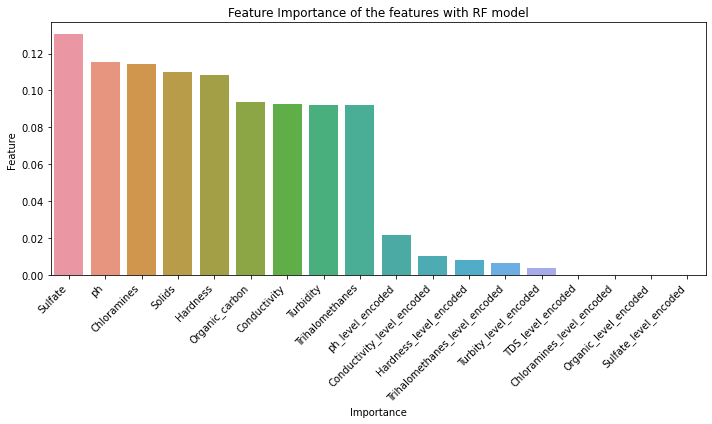

In [116]:
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': Train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the features with RF model')
plt.tight_layout()
plt.show()


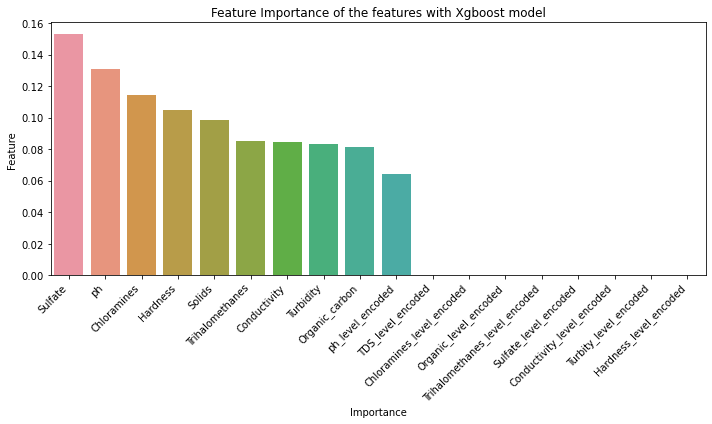

In [117]:
feature_importances1 = xgb_model.feature_importances_
feature_importance_df1 = pd.DataFrame({'Feature': Train.columns, 'Importance': feature_importances1})
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(feature_importance_df1['Feature'], feature_importance_df1['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the features with Xgboost model')
plt.tight_layout()
plt.show()

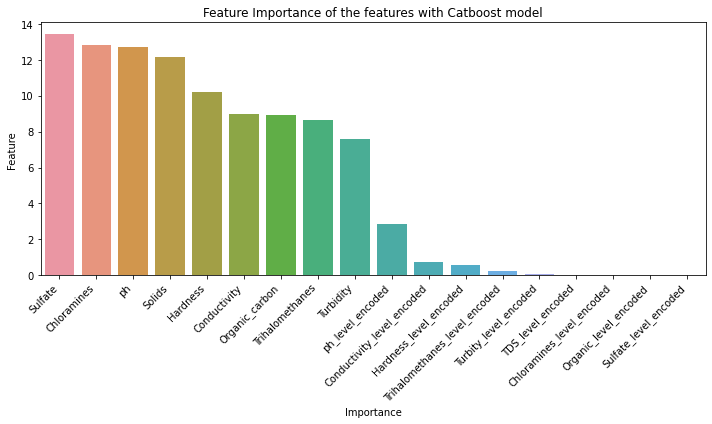

In [118]:
feature_importances2 = cbt_model.feature_importances_
feature_importance_df2 = pd.DataFrame({'Feature': Train.columns, 'Importance': feature_importances2})
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(feature_importance_df2['Feature'], feature_importance_df2['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the features with Catboost model')
plt.tight_layout()
plt.show()

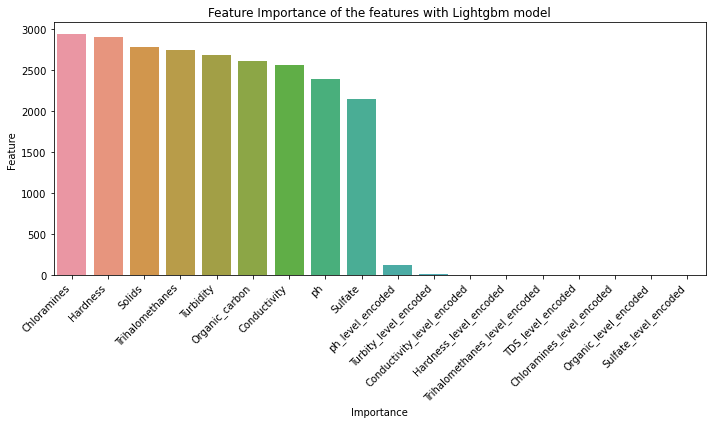

In [119]:
feature_importances3 = lgb_model.feature_importances_
feature_importance_df3 = pd.DataFrame({'Feature': Train.columns, 'Importance': feature_importances3})
feature_importance_df3 = feature_importance_df3.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(feature_importance_df3['Feature'], feature_importance_df3['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the features with Lightgbm model')
plt.tight_layout()
plt.show()

### Testing the Model on Unseen Data

In [104]:
rf_predictions = rf_model.predict(X_test)
rf_score = accuracy_score(y_test,rf_predictions)
rf_score

0.725

In [105]:
lr_predictions = lr_model.predict(X_test)
lr_score = accuracy_score(y_test,lr_predictions)
lr_score

0.4625

In [106]:
xgb_predictions = xgb_model.predict(X_test)
xgb_score = accuracy_score(y_test,xgb_predictions)
xgb_score

0.72

In [107]:
cbt_predictions = cbt_model.predict(X_test)
cbt_score = accuracy_score(y_test,cbt_predictions)
cbt_score

0.7

In [108]:
lgb_predictions = lgb_model.predict(X_test)
lgb_score = accuracy_score(y_test,lgb_predictions)
lgb_score

0.72